# Import Library

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras import optimizers

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Preprocessing

In [3]:
df = pd.read_csv('/content/drive/MyDrive/Dataset/bus_time/dataset.csv')
df.head(3), df.tail(3)

(   Average travel time (min)        date  link
 0                  97.496377  2015-01-01  17:0
 1                 196.464871  2015-01-01   0:4
 2                 295.190476  2015-01-01   4:6,
      Average travel time (min)        date link
 327                 281.385621  2020-06-01  4:6
 328                 191.181373  2020-06-01  6:3
 329                 123.992327  2020-06-01  3:0)

In [4]:
df['link'].unique(), len(df['link'].unique())

(array(['17:0', '0:4', '4:6', '6:3', '3:0'], dtype=object), 5)

In [5]:
data = df.pivot(index = 'date',columns ='link', values =['Average travel time (min)'])
link_col = [data.columns[i][1] for i in range(len(data.columns))]
data.columns = link_col
data.index = pd.to_datetime(data.index)
data

,0:4,17:0,3:0,4:6,6:3
date,,,,,
2015-01-01,196.464871,97.496377,120.291801,295.190476,191.139286
2015-02-01,196.354369,97.368735,120.431304,298.144330,193.148000
2015-03-01,199.736585,99.058394,121.882997,298.211268,193.826087
2015-04-01,199.399103,97.729399,120.936909,297.732394,193.895911
2015-05-01,198.408991,97.530474,120.757258,296.504587,193.298182
...,...,...,...,...,...
2020-02-01,200.912351,99.187831,120.417085,282.523810,187.873077
2020-03-01,201.477848,98.978261,120.000000,283.630000,187.591549
2020-04-01,190.777778,102.928571,124.982456,283.630000,176.478261


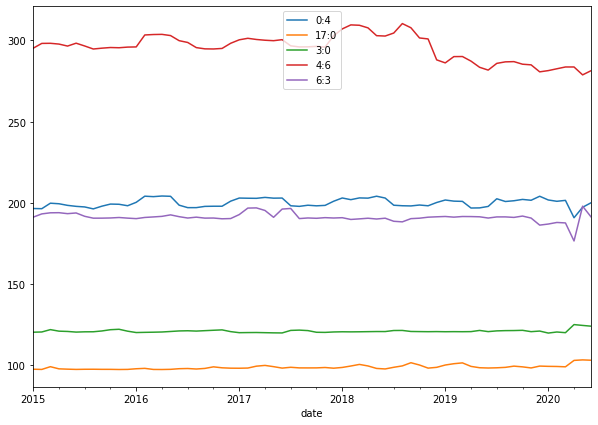

In [6]:
data.plot(figsize=(10,7))

In [7]:
output = (data-data.mean())/data.std()
mean=[]
std=[]
for i in range(len(data.columns)):
  mean.append(data.iloc[:,i].mean())
  std.append(data.iloc[:,i].std())

In [8]:
# temp = data.reset_index()
# date = pd.DataFrame(temp['date'])
# date['month'] = pd.to_datetime(temp['date']).dt.month
# date['year'] = pd.to_datetime(temp['date']).dt.year
# date = date.drop(['date'], axis=1)
# temp['date'] = pd.to_datetime(temp['date']).dt.month
# temp_mean = temp.groupby(temp.date).mean()
# temp_std = temp.groupby(temp.date).std()
# temp = temp.set_index('date')
# date.head()

In [9]:
# for i in range(len(temp_std)):
#   if i == 0:
#     out = (temp[temp.index==i+1]-temp_mean[temp_mean.index==i+1])/temp_std[temp_std.index==i+1]
#     out['year'] = date[date['month']==i+1]['year'].values.tolist()
#     output = out.copy()
#   else:
#     out = (temp[temp.index==i+1]-temp_mean[temp_mean.index==i+1])/temp_std[temp_std.index==i+1]
#     out['year'] = date[date['month']==i+1]['year'].values.tolist()
#     output = pd.concat([output, out])
# output = output.reset_index()
# output['date'] = pd.to_datetime(output.year.astype(str) + '-' + output.date.astype(str))
# output = output.drop(['year'], axis=1).set_index('date').sort_values('date')
# output

In [10]:
lags = 5
preds = 3
data = output.copy()
x = np.stack([np.roll(data, i, axis = 0) for i in range(lags, 0, -1)], axis = 1)[lags:-preds,:,:,np.newaxis,np.newaxis]
y = np.stack([np.roll(data, -i, axis = 0) for i in range(0, preds, 1)], axis = 1)[lags:-preds,:,:,np.newaxis,np.newaxis]
x.shape, y.shape

((58, 5, 5, 1, 1), (58, 3, 5, 1, 1))

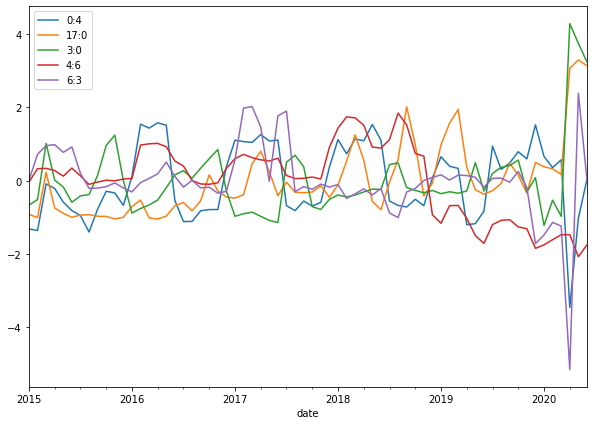

In [11]:
data.plot(figsize=(10,7))

# Modelling

In [12]:
input_timesteps = lags
output_timesteps = preds
num_links = len(df['link'].unique())

def build_model(input_timesteps, output_timesteps, num_links):
    model = Sequential()
    model.add(BatchNormalization(name = 'batch_norm_0', input_shape = (input_timesteps, num_links, 1, 1)))
    model.add(ConvLSTM2D(name ='conv_lstm_1',
                            filters = 64, kernel_size = (5, 1),                       
                            padding = 'same', 
                            return_sequences = True))

    model.add(Dropout(0.2, name = 'dropout_1'))
    model.add(BatchNormalization(name = 'batch_norm_1'))

    model.add(ConvLSTM2D(name ='conv_lstm_2',
                            filters = 64, kernel_size = (5, 1), 
                            padding='same',
                            return_sequences = False))

    model.add(Dropout(0.1, name = 'dropout_2'))
    model.add(BatchNormalization(name = 'batch_norm_2'))

    model.add(Flatten())
    model.add(RepeatVector(output_timesteps))
    model.add(Reshape((output_timesteps, num_links, 1, 64)))

    model.add(ConvLSTM2D(name ='conv_lstm_3',
                            filters = 64, kernel_size = (5, 1), 
                            padding='same',
                            return_sequences = True))

    model.add(Dropout(0.1, name = 'dropout_3'))
    model.add(BatchNormalization(name = 'batch_norm_3'))

    model.add(ConvLSTM2D(name ='conv_lstm_4',
                            filters = 64, kernel_size = (5, 1), 
                            padding='same',
                            return_sequences = True))

    model.add(TimeDistributed(Dense(units=1, name = 'dense_1', activation = 'relu')))
    #model.add(Dense(units=1, name = 'dense_2'))

    optimizer = optimizers.RMSprop() #lr=0.0001, rho=0.9, epsilon=1e-08, decay=0.9)
    model.compile(loss = "mse", optimizer = optimizer)
    return model
model = build_model(input_timesteps, output_timesteps, num_links)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_norm_0 (BatchNormaliz  (None, 5, 5, 1, 1)       4         
 ation)                                                          
                                                                 
 conv_lstm_1 (ConvLSTM2D)    (None, 5, 5, 1, 64)       83456     
                                                                 
 dropout_1 (Dropout)         (None, 5, 5, 1, 64)       0         
                                                                 
 batch_norm_1 (BatchNormaliz  (None, 5, 5, 1, 64)      256       
 ation)                                                          
                                                                 
 conv_lstm_2 (ConvLSTM2D)    (None, 5, 1, 64)          164096    
                                                                 
 dropout_2 (Dropout)         (None, 5, 1, 64)          0

## Train & Test Split

In [13]:
bootstrap_size = int(len(y)*0.75)
n_test = int(len(y)*0.15)
n_windows = 5
stop = min(bootstrap_size + n_windows * n_test, len(y))
bootstrap_size, stop, n_test

(43, 58, 8)

# Training

In [14]:
hist = []
windows = []
for i in range(bootstrap_size, stop, n_test):
    x_train = tf.constant(x[:i,])
    y_train = tf.constant(y[:i,])
    print("shape x_train: ", x_train.shape)
    print("shape y_train: ", y_train.shape)
    x_test = tf.constant(x[i:i+n_test,])
    y_test = tf.constant(y[i:i+n_test,])
    print("shape x_test: ", x_test.shape)
    print("shape y_test: ", y_test.shape)

    model = build_model(input_timesteps, output_timesteps, num_links)
    history = model.fit(x_train, y_train,
                        batch_size = 64, epochs = 30,
                        shuffle = False, validation_data = (x_test, y_test), verbose=0)
    hist.append(history)
    y_pred = model.predict(x_test).squeeze()
    y_test = y_test.numpy().squeeze()
    result=[]
    if preds > 1: # multistep prediction
      for i in range(len(y_pred)):
        out = pd.DataFrame(y_test[i], columns=data.columns.tolist())
        y_true = out*std+mean
        out = pd.DataFrame(y_pred[i], columns=data.columns.tolist())
        y_pred_true = out*std+mean
        error_naive_total_t = (y_true - y_pred_true)
        result.append((np.mean(np.abs(error_naive_total_t) / y_true) * 100))
      print(pd.DataFrame(result))
    else: # one step ahead prediction
      y_true = y_test*std+mean
      y_pred_true = y_pred*std+mean        
      error_naive_total_t = (y_true - y_pred_true)
      percent_error = pd.DataFrame(np.abs(error_naive_total_t)*100/y_true, columns = output.columns.tolist())
      print(percent_error)

shape x_train:  (43, 5, 5, 1, 1)
shape y_train:  (43, 3, 5, 1, 1)
shape x_test:  (8, 5, 5, 1, 1)
shape y_test:  (8, 3, 5, 1, 1)
        0:4      17:0       3:0       4:6       6:3
0  0.568249  1.966825  0.285647  2.523815  0.138107
1  0.852848  1.681840  0.275376  2.380257  0.117363
2  1.244336  1.139401  0.300724  3.154722  0.131521
3  1.495071  0.489999  0.288277  4.156231  0.190021
4  1.323966  0.490262  0.238810  4.320407  0.145075
5  0.895930  0.409804  0.192343  3.911795  0.119641
6  0.704453  0.394427  0.201028  3.271221  0.074300
7  0.628565  0.286801  0.294469  3.326587  0.157056
shape x_train:  (51, 5, 5, 1, 1)
shape y_train:  (51, 3, 5, 1, 1)
shape x_test:  (7, 5, 5, 1, 1)
shape y_test:  (7, 3, 5, 1, 1)
        0:4      17:0       3:0       4:6       6:3
0  0.741901  0.435684  0.328992  3.516694  0.253197
1  1.186931  0.441638  0.234973  4.281787  1.122662
2  1.136758  0.536543  0.441456  4.756741  1.770925
3  1.035139  0.507923  0.517249  5.044915  2.251555
4  0.622234  0.3